# Train Model using a Notebook

This Notebook trains a simple linear regression model on the house-prices data created in `1_create_dataset.ipynb`. Everytime a training run is performed, model performance is logged to an AzureML Experiment.

Using the AzureML Studio interface, it is easy to track model performance accross different training runs. You can find all Experiments and associated training Runs by clicking on Experiments in the sidebar menu.

In [13]:
import joblib
from scripts.utils import (
    compute_metrics,
    histogram_predictions,
    histogram_residuals,
)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit

In [15]:
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core import (
    Workspace,
    Dataset,
    Experiment,
    Run,
    Model,
)

## Settings

In [16]:
# Model settings
model_id = "house_prices_linear_model"
model_path = f"outputs/{model_id}.joblib"
experiment_name = "azureml_demo"

# Cross validation settings
cv_splits = 5
test_prop = .3

## Load Dataset

In [17]:
# Get Dataset from the Workspace
ws = Workspace.from_config()
dataset = Dataset.get_by_name(ws, name='house_prices')
df = dataset.to_pandas_dataframe()

# Split features and labels
X = df.drop(columns="price")
y = df["price"]

## Training

The cell below trains a linear regression model and measures its performance using cross-validation. AzureML provides a number of functions to log metrics inside a run. Here we use `log()` to store details about the size of the training set, proportion that goes into the validation set, number of CV splits and a number of performance metrics. In addition, `log_predictions()` and `log_residuals()` are used to store information about the distribution of the predictions and residuals repectively.

In [18]:
# Set up the experiment
exp = Experiment(ws, experiment_name)

# Create training run
model = LinearRegression()
with exp.start_logging() as run:
    
    # Log training metrics and CV params
    run.log("Training size", X.shape[0])
    run.log("CV splits", cv_splits)
    run.log("CV test proportion", test_prop)
    
    # Run cross-validation
    metrics = []
    results = []
    cv = ShuffleSplit(n_splits=cv_splits, test_size=test_prop)
    for train, test in cv.split(X):
        model.fit(X.loc[train, :], y[train])

        y_true = y[test]
        y_pred = model.predict(X.loc[test, :])

        results.append(
            pd.DataFrame({
                "actual": y_true,
                "predicted": y_pred,
                "residual": y_pred - y_true,
            })
        )

        metrics.append(
            compute_metrics(y_true, y_pred, ["mean_absolute_error", "median_absolute_error", "r2_score"])
        )
    
    results = pd.concat(results)
    metrics = pd.DataFrame(metrics)
    
    # Log accuracy metrics (mean from splits)
    for metric in metrics.columns:
        run.log(metric.replace("_", " ").title(), metrics[metric].mean())

    # Log predictions and residuals histograms
    run.log_predictions("Predictions", histogram_predictions(results["predicted"]))
    run.log_residuals("Residuals", histogram_residuals(results["residual"]))


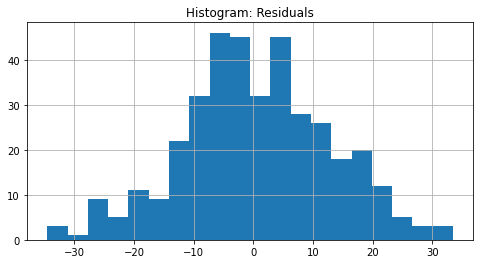

In [8]:
# Plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Histogram: Residuals")
results["residual"].hist(bins=20, ax=ax)

In [9]:
# Print training metrics for each split
metrics

,mean_absolute_error,median_absolute_error,r2_score
0,9.426588,6.791045,0.993414
1,9.543997,8.084147,0.993149
2,10.687916,8.333138,0.992879
3,10.252248,7.839698,0.993967
4,9.552691,7.846736,0.994527


## Register Trained Model

In [20]:
# Create trained model and serialize
reg_model = LinearRegression().fit(X, y)
joblib.dump(reg_model, model_path)

['outputs/house_prices.joblib']

In [21]:
# Generate some example predictions (for future reference)
reg_model.predict([
    [7, 100, 200],
    [4, 70, 10],
])

array([439.43345611, 160.14979954])

In [22]:
# Register the model to the AzureML Workspace
model = Model.register(
    workspace=ws,
    model_name=model_id, 
    model_path=model_path,
    model_framework=Model.Framework.SCIKITLEARN,
    model_framework_version=sklearn.__version__,
    resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5)
)

Registering model house_prices
